In [1]:
import numpy as np
from sklearn.datasets import make_blobs

In [2]:
X, y = make_blobs(
    n_samples = 500,
    n_features = 2,
    random_state = 42,
    centers=[(0, 0)],
    cluster_std=1.0
)

def project_vector_gen():
    v = np.random.multivariate_normal(mean=(0, 0), cov=np.identity(2))
    v = v / np.linalg.norm(v)
    return v

n_projections = 5
projections = [project_vector_gen() for _ in range(n_projections)]
print(projections)

[array([ 0.76344946, -0.64586758]), array([-0.96054741, -0.2781163 ]), array([-0.06096665, -0.9981398 ]), array([ 0.5060927 , -0.86247909]), array([0.95452677, 0.29812522])]


In [3]:
bins = 30
histograms = []

for v in projections:
    projection_values = X.dot(v)
    scalar_min, scalar_max = projection_values.min(), projection_values.max()
    margin = max(1.0, (scalar_max - scalar_min) * 0.5)
    rng = (scalar_min - margin, scalar_max + margin)
    counts, edges = np.histogram(projection_values, bins=bins, range = rng)
    probs = counts.astype(float) / counts.sum()
    histograms.append((edges, probs))

In [4]:
def score_points(X_points, projections, histograms):
    scores = np.zeros(len(X_points), dtype=float)
    for i, x in enumerate(X_points):
        p_vals = []
        for v, (edges, probs) in zip(projections, histograms):
            pv = x.dot(v)
            idx = np.digitize(pv, edges) - 1
            idx = np.clip(idx, 0, len(probs) - 1)
            p_vals.append(probs[idx])
        scores[i] = np.mean(p_vals)
    return scores

# 3) testing: uniform data between -3 and 3
X_test = np.random.uniform(-3, 3, size=(500, 2))
test_scores = score_points(X_test, projections, histograms)

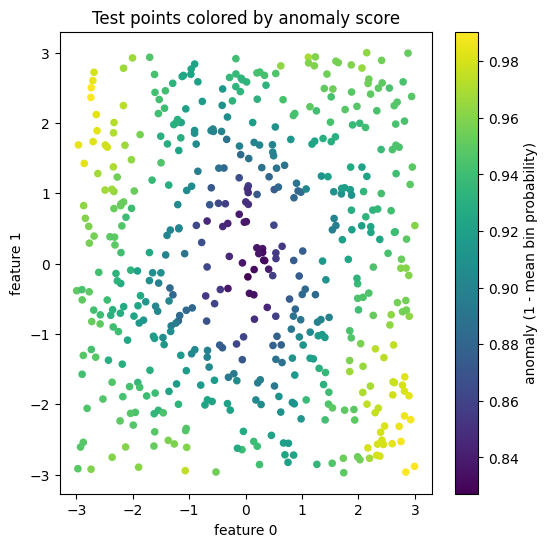

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
sc = plt.scatter(X_test[:, 0], X_test[:, 1], c=1 - test_scores, cmap='viridis', s=20)
plt.colorbar(sc, label='anomaly (1 - mean bin probability)')
plt.title('Test points colored by anomaly score')
plt.xlabel('feature 0')
plt.ylabel('feature 1')
plt.show()

In [ ]:
bin_sizes = [2, 3, 5, 10, 15, 20]
all_histograms = {}

for bins in bin_sizes:
    histograms = []
    for v in projections:
        projection_values = X.dot(v)
        scalar_min, scalar_max = projection_values.min(), projection_values.max()
        margin = max(1.0, (scalar_max - scalar_min) * 0.5)
        rng = (scalar_min - margin, scalar_max + margin)
        counts, edges = np.histogram(projection_values, bins=bins, range=rng)
        probs = counts.astype(float) / counts.sum()
        histograms.append((edges, probs))
    all_histograms[bins] = histograms

all_scores = {}

for bins in bin_sizes:
    test_scores = score_points(X_test, projections, all_histograms[bins])
    all_scores[bins] = test_scores
    print(f"Scored test points for {bins} bins - mean score: {test_scores.mean():.4f}")

Scored test points for 2 bins - mean score: 0.5144
Scored test points for 3 bins - mean score: 0.7089
Scored test points for 5 bins - mean score: 0.4189
Scored test points for 10 bins - mean score: 0.2200
Scored test points for 15 bins - mean score: 0.1485
Scored test points for 20 bins - mean score: 0.1114


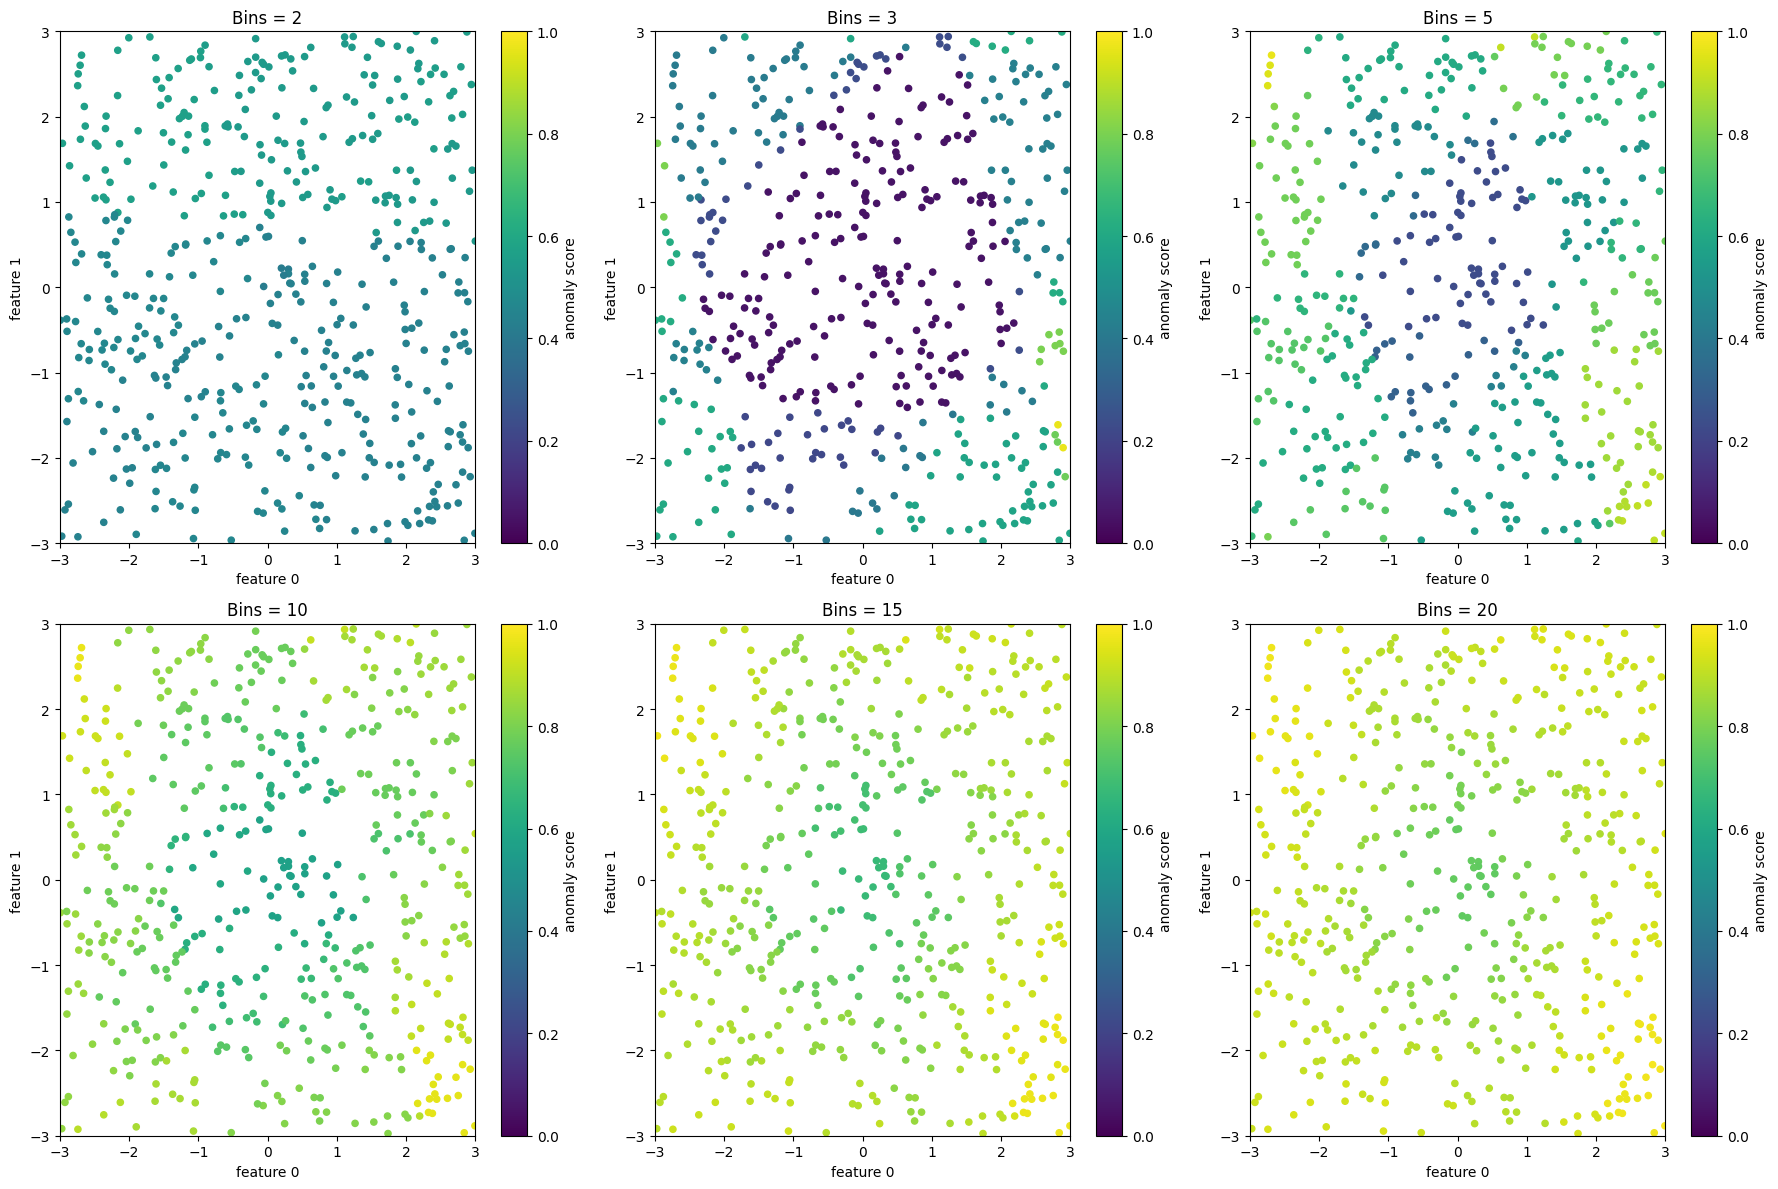

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, bins in enumerate(bin_sizes):
    ax = axes[idx]
    sc = ax.scatter(X_test[:, 0], X_test[:, 1], 
                    c=1 - all_scores[bins], 
                    cmap='viridis', 
                    s=20,
                    vmin=0, vmax=1)
    plt.colorbar(sc, ax=ax, label='anomaly score')
    ax.set_title(f'Bins = {bins}')
    ax.set_xlabel('feature 0')
    ax.set_ylabel('feature 1')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

plt.tight_layout()
plt.show()